In [34]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [35]:
#%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline/
#fs= xr.open_dataset('static.nc', decode_times=False)
#av = xr.open_dataset('averages_00001402.nc',decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_QG_Leith_v1/
# fs_QGleith1 = xr.open_dataset('static.nc', decode_times=False)
# av_QGleith1 = xr.open_dataset('averages_00000102.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_QG_Leith_v2/
# fs_QGleith2 = xr.open_dataset('static.nc', decode_times=False)
# av_QGleith2 = xr.open_dataset('averages_00000102.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_QG_Leith_v3/
fs = xr.open_dataset('static.nc', decode_times=False)
av= xr.open_mfdataset(['averages_00001302.nc','averages_00001402.nc'], decode_times=False)


%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/scratch/gmarques/NW2_TMP/nw2_0.03125deg_N15_QG_Leith_v3
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [36]:
%%time
xh= fs.xh.values
yh = fs.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(40, 15, 4480, 1920)
CPU times: user 23.8 ms, sys: 1.17 ms, total: 25 ms
Wall time: 23.9 ms


In [37]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot_003125=KE_eddy_BT+KE_mean_BT
KE_BC_tot_003125=KE_eddy_BC+KE_mean_BC
KE_tot_003125=KE_BT_tot_003125+KE_BC_tot_003125


fraction_BT_003125=KE_BT_tot_003125/KE_tot_003125
fraction_BT_mean_003125=KE_mean_BT/KE_tot_003125
fraction_BT_eddy_003125=KE_eddy_BT/KE_tot_003125

fraction_BC_003125=KE_BC_tot_003125/KE_tot_003125 #when you divide zero/zero it's a nan
fraction_BC_mean_003125=KE_mean_BC/KE_tot_003125
fraction_BC_eddy_003125=KE_eddy_BC/KE_tot_003125

KE_eddy_003125 = KE_eddy_BT+ KE_eddy_BC
KE_mean_003125 = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 93.1 ms, sys: 2.17 ms, total: 95.2 ms
Wall time: 93.6 ms


In [38]:
fraction_BT_003125.shape

(4480, 1920)

done


Text(0.5, 1.0, '1/32$^\\circ$ KE Fractions, Biharmonic Smagorinsky')

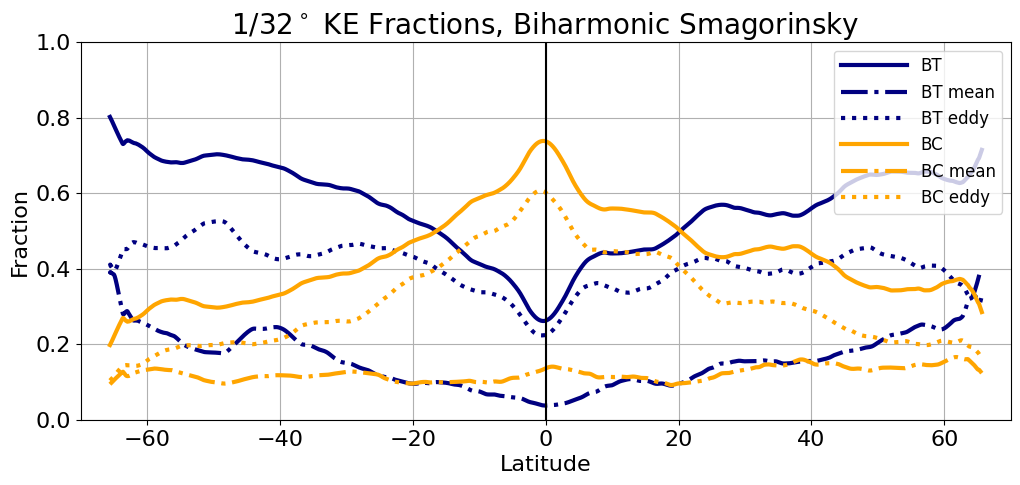

In [23]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.plot(yh,np.convolve((fraction_BT_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
plt.plot(yh,np.convolve((fraction_BT_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.plot(yh,np.convolve((fraction_BC_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
plt.plot(yh,np.convolve((fraction_BC_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT mean','BT eddy','BC','BC mean','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$ KE Fractions, Biharmonic Smagorinsky',fontsize=20)

done


Text(0.5, 1.0, '1/32$^\\circ$ KE Fractions, Biharmonic Smagorinsky')

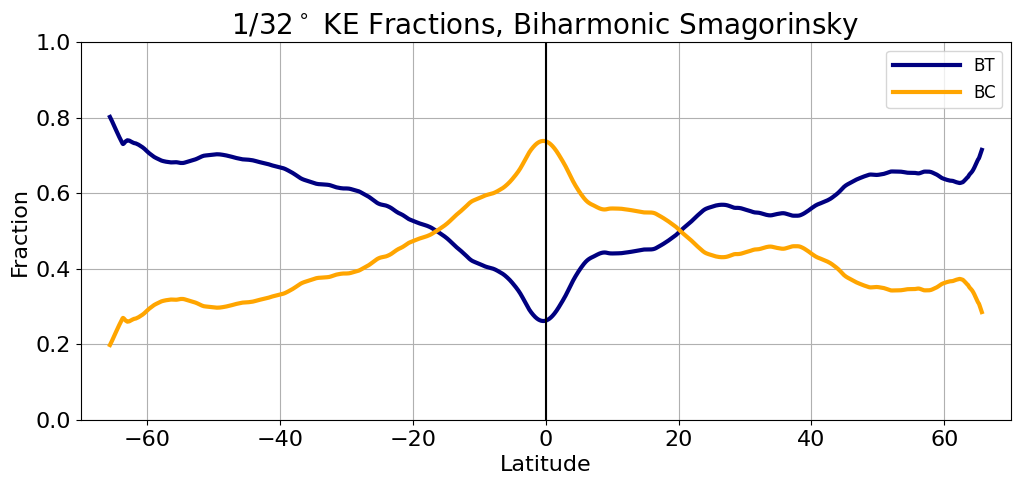

In [22]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.grid()
plt.plot(yh,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$ KE Fractions, Biharmonic Smagorinsky',fontsize=20)

done


Text(0.5, 1.0, '1/32$^\\circ$ KE Fractions, QG Leith')

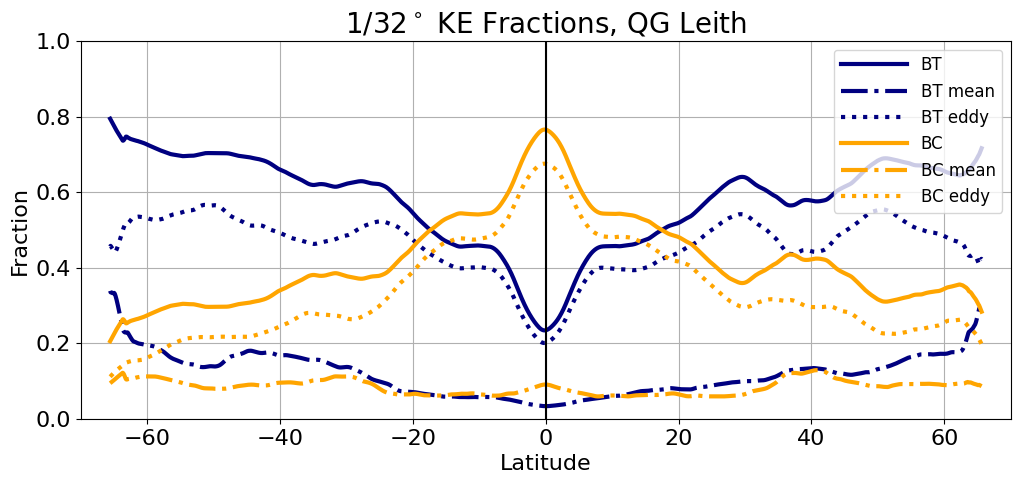

In [39]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.plot(yh,np.convolve((fraction_BT_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
plt.plot(yh,np.convolve((fraction_BT_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()
plt.plot(yh,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.plot(yh,np.convolve((fraction_BC_mean_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
plt.plot(yh,np.convolve((fraction_BC_eddy_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)

plt.legend(['BT','BT mean','BT eddy','BC','BC mean','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$ KE Fractions, QG Leith',fontsize=20)

done


Text(0.5, 1.0, '1/32$^\\circ$ KE Fractions, QG Leith')

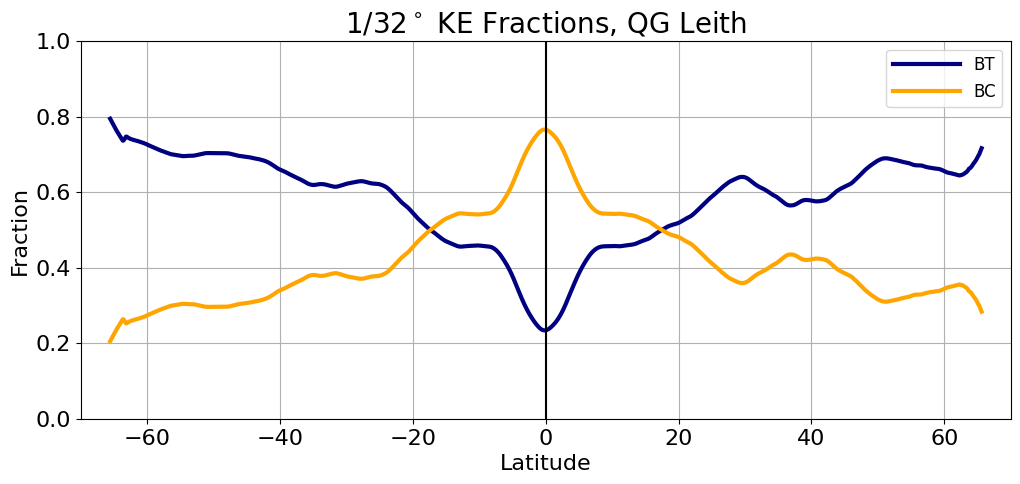

In [40]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3)
print('done')
plt.grid()
plt.plot(yh,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$ KE Fractions, QG Leith',fontsize=20)